In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import sys
import scipy
sys.path.append('/Users/ruby/EoR/pyuvdata')
from pyuvdata import UVData
import scipy.optimize

In [3]:
# Load data from pyuvsim simulation:
path = '/Users/ruby/EoR/compact_redundant_array_sim_May2020'
data_sim = UVData()
data_sim.read_uvh5('{}/square_grid_sim__results.uvh5'.format(path))

# Inflate data
print(np.shape(data_sim.baseline_array))
data_sim.inflate_by_redundancy()
print(np.shape(data_sim.baseline_array))

# Remove autos
data_sim.select(ant_str='cross')
# Use only XX polarizations
data_sim.select(polarizations=[-5])

# Convert baselines to have u>0
data_sim.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

Telescope square_grid is not in known_telescopes.


(61,)
(666,)


In [4]:
# Load model from pyuvsim simulation
path = '/Users/ruby/EoR/compact_redundant_array_sim_May2020'
model_sim = UVData()
model_sim.read_uvh5('{}/square_grid_100mjy_sim_results.uvh5'.format(path))
# Remove autos
model_sim.select(ant_str='cross')
# Use only XX polarizations
model_sim.select(polarizations=[-5])
# Convert baselines to have u>0
model_sim.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

Telescope square_grid is not in known_telescopes.


In [5]:
baseline_groups, vec_bin_centers, lengths, conjugates = data_sim.get_redundancies(
    tol=0.1, use_antpos=False, include_conjugates=True, include_autos=True, conjugate_bls=False
)

In [8]:
print(np.mean(np.shape([baseline_groups[ind] for ind in range(np.shape(baseline_groups)[0])])[0]))

60.0


In [9]:
# Create the baseline covariance matrix
baseline_cov_array = np.diag(np.full(np.shape(baseline_groups)[0], 1.))
min_bl_length = 14.
tolerance = .01
for bl_1 in range(np.shape(baseline_groups)[0]):
    for bl_2 in [ind for ind in range(np.shape(baseline_groups)[0]) if ind != bl_1]:
        bl_separation_sq = (
            (vec_bin_centers[bl_1, 0]-vec_bin_centers[bl_2, 0])**2
            + (vec_bin_centers[bl_1, 1]-vec_bin_centers[bl_2, 1])**2
        )
        if (min_bl_length-tolerance)**2 <= bl_separation_sq <= (min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.1617
        elif 2*(min_bl_length-tolerance)**2 <= bl_separation_sq <= 2*(min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.0176
# Check that the covariance matrix is full-rank
print(np.shape(baseline_cov_array)[0])
print(np.linalg.matrix_rank(baseline_cov_array))
# Invert the matrix
baseline_cov_inv = np.linalg.inv(baseline_cov_array)

60
60


In [10]:
# Grab model visibilities
model_visibilities = np.zeros(np.shape(baseline_groups)[0], dtype=np.complex_)

if True: # Use this if the same data is used for the data and model
    for red_group in range(np.shape(baseline_groups)[0]):
       # Use first visiblity in each redundant group
        model_visibilities[red_group] = data_sim.data_array[
            np.where(data_sim.baseline_array == baseline_groups[red_group][0])[0], 0, 0, 0
        ]
else: # Use this if a different model is read in
    tolerance = .001
    for bl in range(np.shape(model_sim.uvw_array)[0]):
        red_group = np.intersect1d(
            np.where(np.abs(model_sim.uvw_array[bl, 0] - vec_bin_centers[:, 0]) < tolerance)[0],
            np.where(np.abs(model_sim.uvw_array[bl, 1] - vec_bin_centers[:, 1]) < tolerance)[0]
        )
        if np.shape(red_group)[0] != 1:
            print('ERROR: More than one redundant bin found.')
        model_visibilities[red_group[0]] = model_sim.data_array[bl, 0, 0, 0]

In [11]:
# Initialize the fitted visibilities to the model visibility values
visibilities_initialize = np.copy(model_visibilities)
# Initialize the gains to 1
gains_initialize = np.full(data_sim.Nants_data, 1.+0.j)
# Perturb the initial guess for the gains
stddev = .01
gains_noise = np.random.normal(0, stddev, data_sim.Nants_data) + 1j*np.random.normal(0, stddev, data_sim.Nants_data)
gains_initialize += gains_noise
gains_phase = np.mean(np.angle(gains_initialize))
gains_initialize *= (np.cos(gains_phase) - 1j*np.sin(gains_phase)) # Enforce that the degenerate overall phase is zero
# Expand the initialized values
x0 = np.concatenate((
    np.real(gains_initialize), np.imag(gains_initialize),
    np.real(visibilities_initialize), np.imag(visibilities_initialize)
))

In [12]:
# Create the A matrix
a_mat = np.zeros((data_sim.Nbls, np.shape(baseline_groups)[0]))
for red_group in range(np.shape(baseline_groups)[0]):
    for baseline in baseline_groups[red_group]:
        a_mat[np.where(data_sim.baseline_array == baseline)[0], red_group] = 1

In [13]:
# Check that the A matrix is correct
dummy_vis = np.full(60, 1.)
dummy_vis_expanded = np.matmul(a_mat, dummy_vis)
print(dummy_vis_expanded)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [14]:
# Create gains expand matrices
gains_exp_mat_1 = np.zeros((data_sim.Nbls, data_sim.Nants_data), dtype=np.int)
gains_exp_mat_2 = np.zeros((data_sim.Nbls, data_sim.Nants_data), dtype=np.int)
for baseline in range(data_sim.Nbls):
    gains_exp_mat_1[baseline, data_sim.ant_1_array[baseline]] = 1
    gains_exp_mat_2[baseline, data_sim.ant_2_array[baseline]] = 1

In [15]:
def cost_function(
    x, 
    N_red_baselines, Nants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, model_variance
):

    fitted_visibilities = x[-2*N_red_baselines:-N_red_baselines]+1j*x[-N_red_baselines:]
    gains = x[:Nants]+1j*x[Nants:2*Nants]
    
    vis_diff = fitted_visibilities-model_visibilities
    prior = np.abs(np.dot(np.matmul(np.conj(vis_diff), baseline_cov_array), vis_diff))
    
    fitted_visibilities_expanded = np.matmul(a_mat, fitted_visibilities)
    gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
    prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
    
    return prob+prior/model_variance

In [16]:
def cost_function_sky_cal(
    x, 
    Nants, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities
):

    gains = x[:Nants]+1j*x[Nants:2*Nants]
    
    fitted_visibilities_expanded = np.matmul(a_mat, model_visibilities)
    gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
    prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
    
    return prob

In [17]:
def add_visibility_noise(visibilities, stddev):
    noise_real = np.random.normal(0, stddev, np.shape(visibilities))
    noise_imag = np.random.normal(0, stddev, np.shape(visibilities))
    noisy_visibilities = np.copy(visibilities)
    noisy_visibilities += noise_real + 1j*noise_imag
    return noisy_visibilities

Optimization terminated successfully.


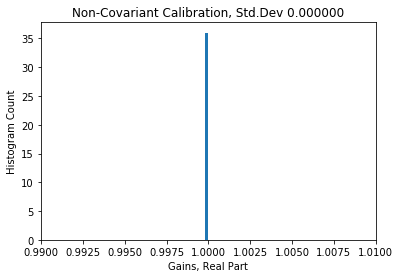

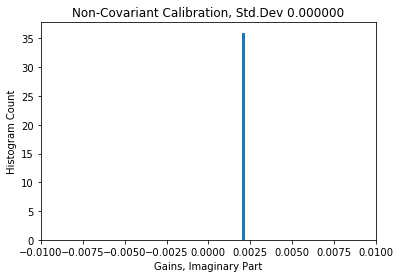

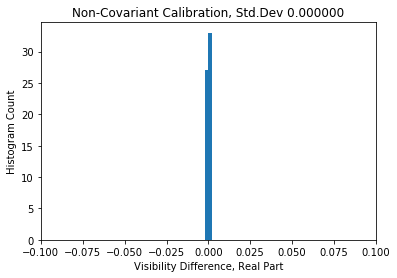

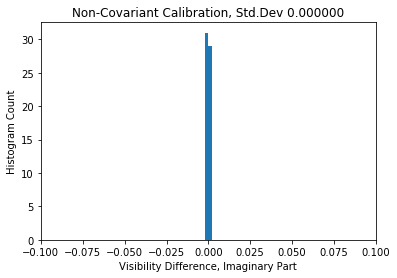

In [13]:
# Use a perfect model and no thermal noise:
# Solutions converge perfectly

n_trials=1
noise_level = 0
model_variance = 100
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)
    
    # Create data visibilities
    baseline_no_cov_inv = np.diag(np.full(np.shape(baseline_groups)[0], 1.)) # no baseline covariance

    result_no_cov = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_no_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, model_variance
        ),
        method=method, options={'maxiter':maxiter}
    )
    print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    vis_fit_no_cov = result_no_cov.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result_no_cov.x[-np.shape(baseline_groups)[0]:]
    vis_diff_vals[:, trial] = vis_fit_no_cov - model_visibilities # in this case, the model visibilities are the true visibilities
    
# Plot the results

plot_range = .01
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .1
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(vis_diff_vals)))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(vis_diff_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

In [14]:
# Use a perfect model with one gain=2

n_trials=1
noise_level = 0
model_variance = 100
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)
data_visibilities[np.where(data_sim.ant_1_array == 5)] *= 2
data_visibilities[np.where(data_sim.ant_2_array == 5)] *= 2

for trial in range(n_trials):
    
    # Create data visibilities
    baseline_no_cov_inv = np.diag(np.full(np.shape(baseline_groups)[0], 1.)) # no baseline covariance

    result_no_cov = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_no_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, model_variance
        ),
        method=method, options={'maxiter':maxiter}
    )
    print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    vis_fit_no_cov = result_no_cov.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result_no_cov.x[-np.shape(baseline_groups)[0]:]
    vis_diff_vals[:, trial] = vis_fit_no_cov - model_visibilities # in this case, the model visibilities are the true visibilities
    
print(gain_vals)

Optimization terminated successfully.
[[0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [1.99999555+0.0042189j ]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]
 [0.99999778+0.00210945j]]


Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization

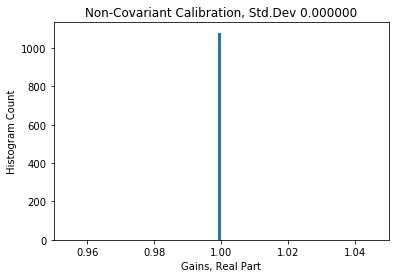

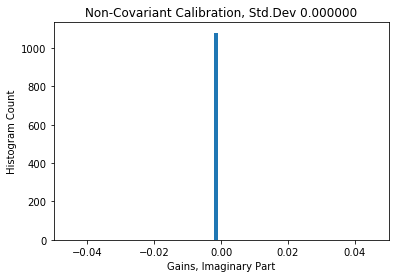

In [38]:
# Sky cal without thermal noise

n_trials=30
noise_level = 0
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)
    
    # Create data visibilities
    baseline_no_cov_inv = np.diag(np.full(np.shape(baseline_groups)[0], 1.)) # no baseline covariance
    gains0 = x0[:2*data_sim.Nants_data]

    result_no_cov = scipy.optimize.minimize(
        cost_function_sky_cal, gains0, 
        args=(
            data_sim.Nants_data, model_visibilities, a_mat, gains_exp_mat_1, 
            gains_exp_mat_2, data_visibilities
        ),
        method=method, options={'maxiter':maxiter}
    )
    print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    
# Plot the results

plot_range = .05
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

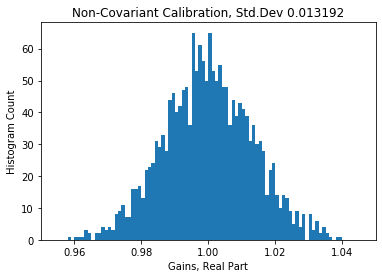

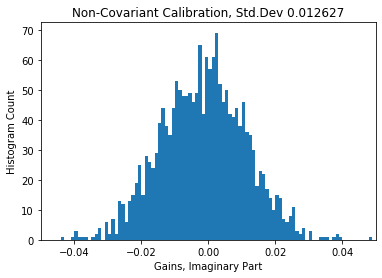

In [54]:
# Sky cal with thermal noise

n_trials=50
noise_level = .5
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)
    
    # Create data visibilities
    baseline_no_cov_inv = np.diag(np.full(np.shape(baseline_groups)[0], 1.)) # no baseline covariance
    gains0 = x0[:2*data_sim.Nants_data]

    result_no_cov = scipy.optimize.minimize(
        cost_function_sky_cal, gains0, 
        args=(
            data_sim.Nants_data, model_visibilities, a_mat, gains_exp_mat_1, 
            gains_exp_mat_2, data_visibilities
        ),
        method=method, options={'maxiter':maxiter,'ftol': 0.0000001}
    )
    #print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    
# Plot the results

plot_range = .05
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization

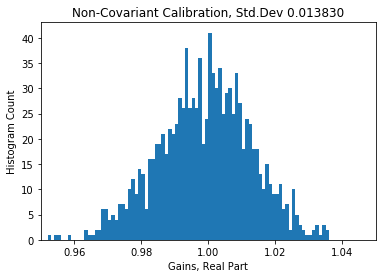

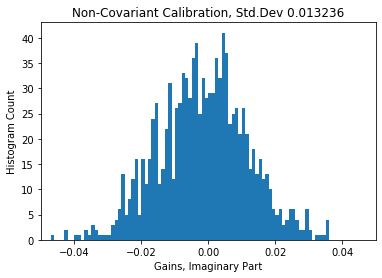

In [53]:
# Use those wrong visibilities as the model for sky cal

n_trials=30
noise_level = .5
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)
    model_visibilities_fit = vis_diff_vals[:, trial] + model_visibilities
    
    # Create data visibilities
    baseline_no_cov_inv = np.diag(np.full(np.shape(baseline_groups)[0], 1.)) # no baseline covariance
    gains0 = x0[:2*data_sim.Nants_data]

    result_no_cov = scipy.optimize.minimize(
        cost_function_sky_cal, gains0, 
        args=(
            data_sim.Nants_data, model_visibilities_fit, a_mat, gains_exp_mat_1, 
            gains_exp_mat_2, data_visibilities
        ),
        method=method, options={'maxiter':maxiter,'ftol': 0.0000001}
    )
    print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    
# Plot the results

plot_range = .05
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

In [40]:
np.mean(np.abs(data_visibilities))

5.87168165815413

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization

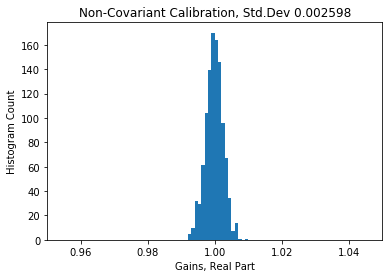

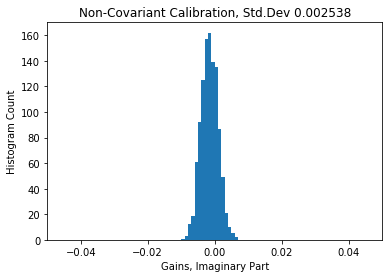

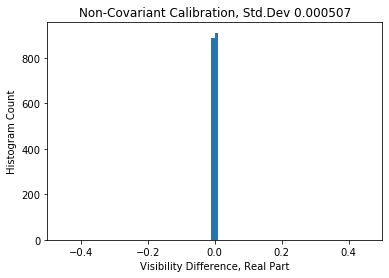

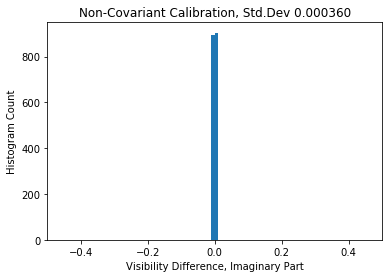

In [30]:
# Perfect model with thermal noise:
# Less variance around the model is permitted
# The variance on the fitted visibilities is much better,
# surprisingly there is not much effect on the gains

n_trials=30
noise_level = .1
model_variance = .001
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)
    
    # Create data visibilities
    baseline_no_cov_inv = np.diag(np.full(np.shape(baseline_groups)[0], 1.)) # no baseline covariance

    result_no_cov = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_no_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, model_variance
        ),
        method=method, options={'maxiter':maxiter}
    )
    print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    vis_fit_no_cov = result_no_cov.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result_no_cov.x[-np.shape(baseline_groups)[0]:]
    vis_diff_vals[:, trial] = vis_fit_no_cov - model_visibilities # in this case, the model visibilities are the true visibilities
    
# Plot the results

plot_range = .05
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(vis_diff_vals)))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(vis_diff_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization

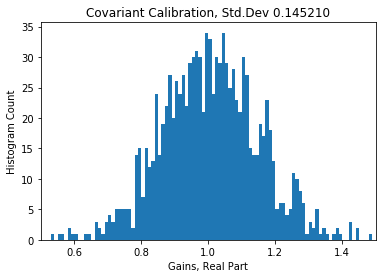

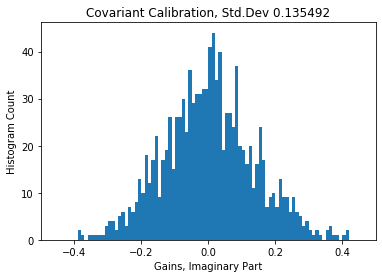

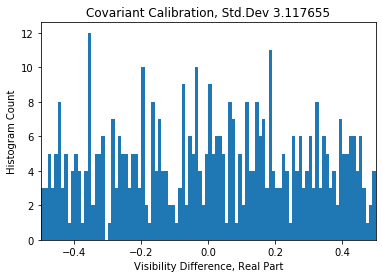

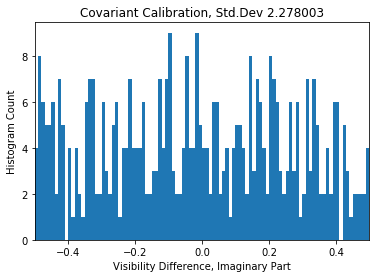

In [53]:
# Covariant calibration
# High model variance

n_trials=30
noise_level = 5
model_variance = 100
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)

    result_no_cov = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, model_variance
        ),
        method=method, options={'maxiter':maxiter}
    )
    print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    vis_fit_no_cov = result_no_cov.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result_no_cov.x[-np.shape(baseline_groups)[0]:]
    vis_diff_vals[:, trial] = vis_fit_no_cov - model_visibilities # in this case, the model visibilities are the true visibilities
    
# Plot the results

plot_range = .5
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(vis_diff_vals)))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(vis_diff_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization

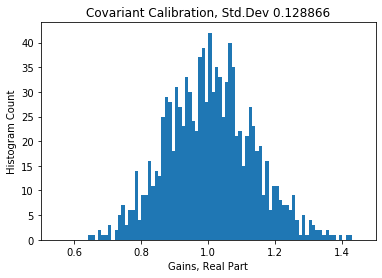

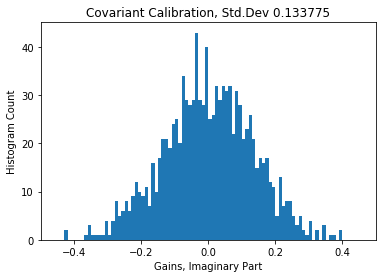

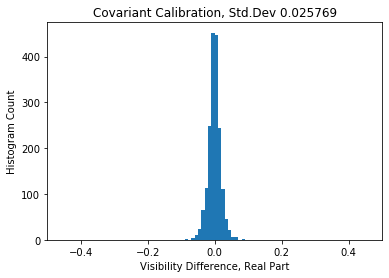

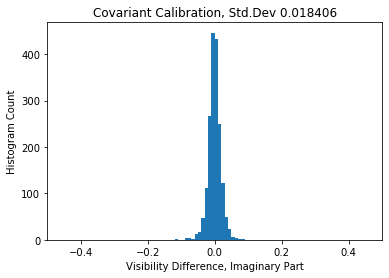

In [54]:
# Covariant calibration

n_trials=30
noise_level = 5
model_variance = .001
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)

    result_no_cov = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, model_variance
        ),
        method=method, options={'maxiter':maxiter}
    )
    print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    vis_fit_no_cov = result_no_cov.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result_no_cov.x[-np.shape(baseline_groups)[0]:]
    vis_diff_vals[:, trial] = vis_fit_no_cov - model_visibilities # in this case, the model visibilities are the true visibilities
    
# Plot the results

plot_range = .5
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(vis_diff_vals)))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(vis_diff_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

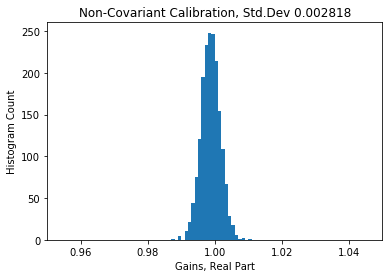

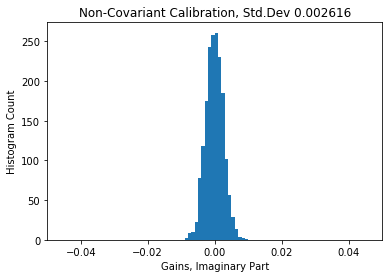

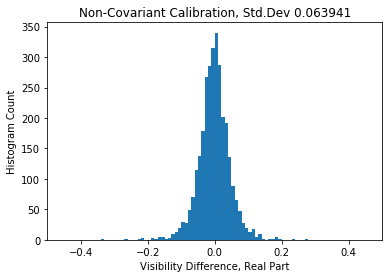

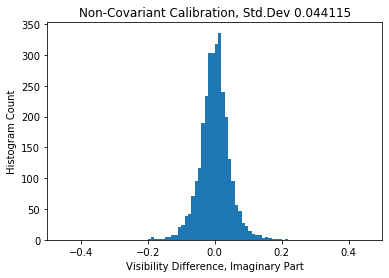

In [18]:
# Keep the perfect model but introduce thermal noise:
# Solutions have some spread around their true values

n_trials=50
noise_level = .1
model_variance = 100
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)
    
    # Create data visibilities
    baseline_no_cov_inv = np.diag(np.full(np.shape(baseline_groups)[0], 1.)) # no baseline covariance

    result_no_cov = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_no_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, model_variance
        ),
        method=method, options={'maxiter':maxiter,'ftol': 0.0000001}
    )
    #print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    vis_fit_no_cov = result_no_cov.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result_no_cov.x[-np.shape(baseline_groups)[0]:]
    vis_diff_vals[:, trial] = vis_fit_no_cov - model_visibilities # in this case, the model visibilities are the true visibilities
    
# Plot the results

plot_range = .05
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(vis_diff_vals)))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(vis_diff_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

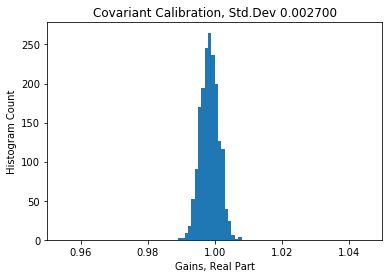

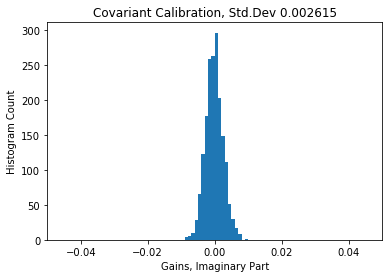

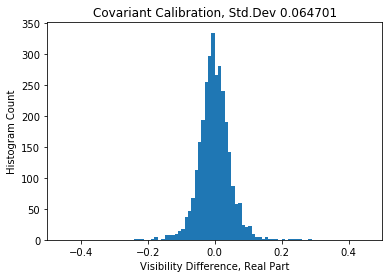

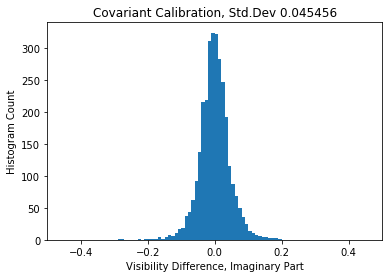

In [20]:
# Covariant calibration

n_trials=50
noise_level = .1
model_variance = 100
#method = 'Nelder-Mead'
method = 'Powell'
maxiter = 100000

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], noise_level)

    result_no_cov = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, model_variance
        ),
        method=method, options={'maxiter':maxiter}
    )
    #print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:data_sim.Nants_data]+1j*result_no_cov.x[data_sim.Nants_data:2*data_sim.Nants_data]
    gain_vals[:, trial] = gains_fit_no_cov
    vis_fit_no_cov = result_no_cov.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result_no_cov.x[-np.shape(baseline_groups)[0]:]
    vis_diff_vals[:, trial] = vis_fit_no_cov - model_visibilities # in this case, the model visibilities are the true visibilities
    
# Plot the results

plot_range = .05
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins+1)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
nbins = 100
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(vis_diff_vals)))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(vis_diff_vals))))
plt.xlim(-1*plot_range, plot_range)
plt.show()